In [41]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2024)

tc = create_taiga_client_v3()


In [249]:

class OrderParamClassifier:
    """to classify samples based on their gene expression profiles and their corresponding cell or disease type annotations. """
    def __init__(self, expr, markers, num_samples): 
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples= num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)

def get_gene_map(tc):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type','entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()),'depmap'] = np.nan
    #ensembl = generateGeneNames(attributes=['ensembl_transcript_id'])
    #hgnc['ensembl_transcript_id'] = pd.merge(hgnc.ensembl_gene_id,ensembl.set_index('ensembl_gene_id').ensembl_transcript_id)
    return hgnc

def get_tcga_classifier(num_samples):
    """
    """
    # Get and fill missing values with 0 in TCGA expression data
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    
    # Get DepMap expression data
    depmap = tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
    
    # Retrieve gene map
    gene_map = get_gene_map(tc)
    
    # Rename DepMap expression data columns based on gene map ensembl_gene_id column 
    expr_depmap = depmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())
    
    # Identify common genes between TCGA and DepMap expression data
    commongenes = tcga_expr.columns.intersection(expr_depmap.columns)
    
    # Subset TCGA expression data to keep only the common genes
    tcga_expr = tcga_expr[commongenes]
    
    # Read TCGA metadata 
    tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv')
    # Update derived_subtype and new_subtype columns
    tcga_meta.loc[tcga_meta['subtype'] == 'colon adenocarcinoma', ['derived_subtype', 'new_subtype']] = 'colon adenocarcinoma'
    # Update derived_lineage to 'adeno' where new_subtype is 'adeno'
    tcga_meta.loc[tcga_meta['new_subtype'] == 'adeno', 'derived_lineage'] = 'adeno'

    # Update derived_lineage to 'squamous' where new_subtype is 'squamous'
    tcga_meta.loc[tcga_meta['new_subtype'] == 'squamous', 'derived_lineage'] = 'squamous'



    # Set sampleID as index and get the new_subtype column for annotations
    tcga_ann = tcga_meta.set_index('sampleID').derived_lineage
    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier


def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [248]:
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv')
# Update derived_subtype and new_subtype columns
tcga_meta.loc[tcga_meta['subtype'] == 'colon adenocarcinoma', ['derived_subtype', 'new_subtype']] = 'colon adenocarcinoma'
# Update derived_lineage to 'adeno' where new_subtype is 'adeno'
tcga_meta.loc[tcga_meta['new_subtype'] == 'adeno', 'derived_lineage'] = 'adeno'
# Update derived_lineage to 'squamous' where new_subtype is 'squamous'
tcga_meta.loc[tcga_meta['new_subtype'] == 'squamous', 'derived_lineage'] = 'squamous'


In [176]:
def update_subtype2(row):
    if row['derived_lineage'] == 'CNS/Brain':
        if 'Medulloblastoma' not in row['new_subtype']:
            return 'CNS/Brain'
    return row['new_subtype']

# Apply the function to update the 'new_subtype' column
#tcga_meta['new_subtype'] = tcga_meta.apply(update_subtype2, axis=1)
#tcga_meta['new_subtype'] = tcga_meta.apply(update_subtype, axis=1)

In [283]:
tcga_meta[['sampleID', 'new_subtype']].to_csv('/Users/nabdirah/Project1/tcga_samplesubtype.csv')

In [224]:
debmap=tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
metadata = tc.get('internal-24q2-3719.82/Model')
gene_map=get_gene_map(tc)
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())	# get the ensembl_gene_id column from gene_map 
#and replace the columns depmap to the values in this column 
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna()) 

In [ ]:
# the number of train samples for each subtype 
num_samples = 25
# Get the TCGA classifier with the specified number of samples
classifier = get_tcga_classifier(num_samples)
# Train the classifier
classifier.train()

In [257]:
# Identify the common genes between the columns of expr_depmap and the columns of classifier.exp
# Score the expression data from expr_depmap for the common genes using the classifier
# Drop columns with any missing values (NaN) before scoring
# Extract the projections
common_genes = expr_depmap.columns.intersection(classifier.expr.columns) 
score_data=classifier.score(expr_depmap[common_genes].dropna(axis=1))
projections=score_data[0] # a Dataframe with columns as the samples and the rows as the subtypes 

In [258]:
oncotree=pd.read_csv('/Users/nabdirah/Project1/updated_oncotree.csv')

In [290]:
projections.to_csv('/Users/nabdirah/Project1/lineageprojection.csv')

In [259]:
projections=projections.T

In [291]:
unique_df=pd.read_csv('/Users/nabdirah/Project1/7bigsubtype.csv')

In [292]:
def update_derived_lineage(df):
    def update_lineage(row):
        if row['new_subtype'] == 'adeno':
            return 'adeno'
        elif row['new_subtype']== 'squamous':
            return 'squamous'
        return row['Lineage']

    # Apply the update_lineage function to each row
    df['Lineage'] = df.apply(update_lineage, axis=1)
    return df
updated= update_derived_lineage(unique_df)

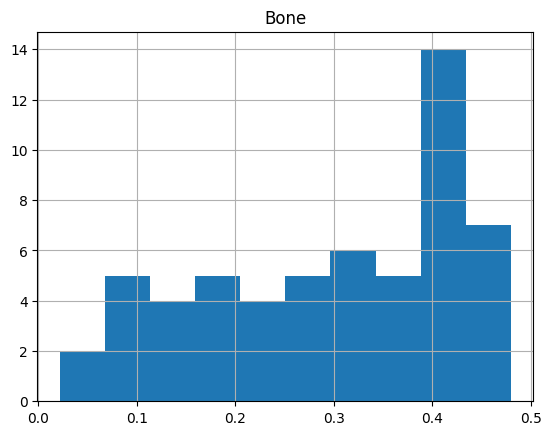

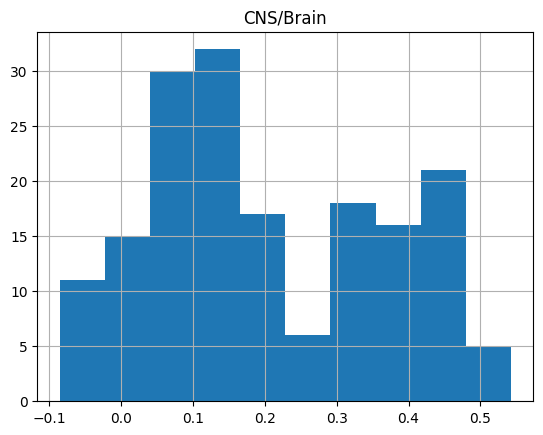

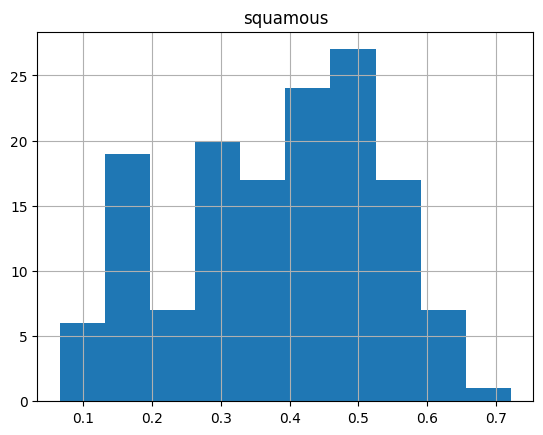

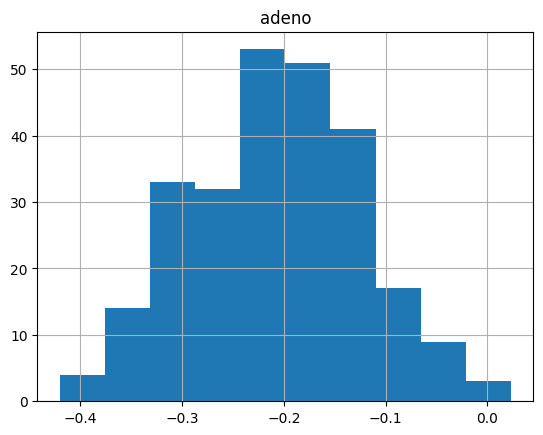

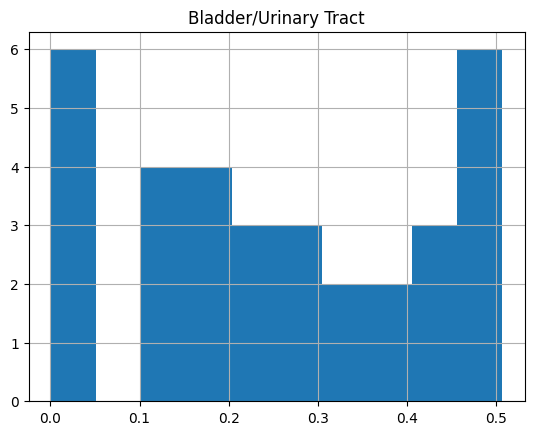

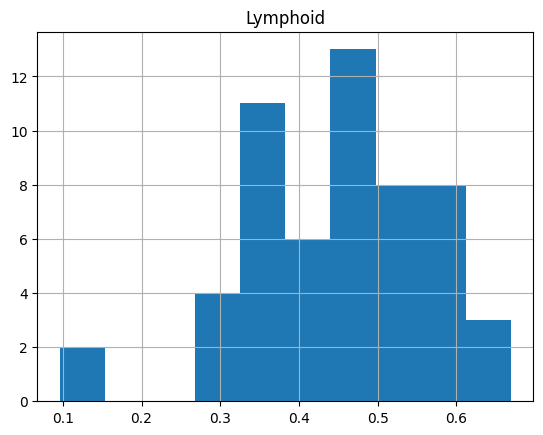

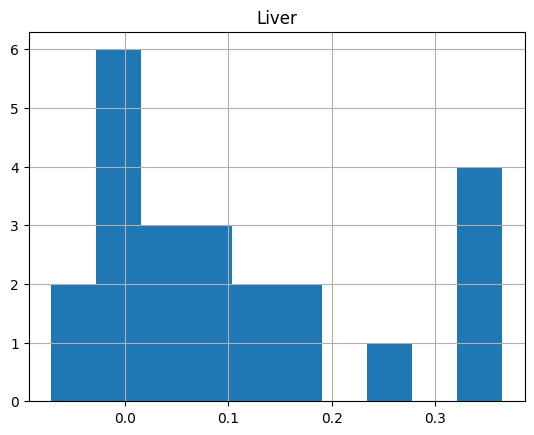

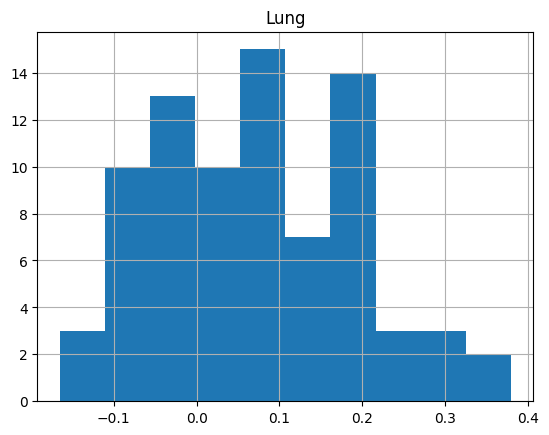

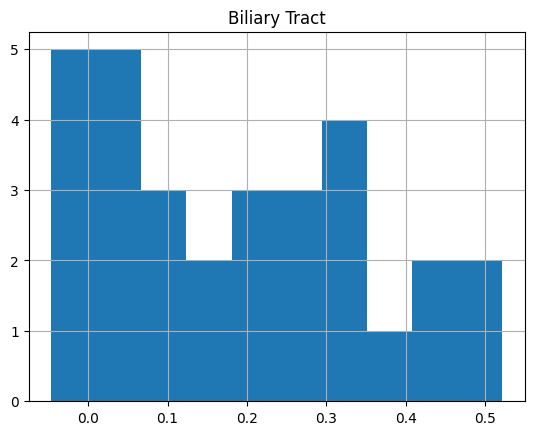

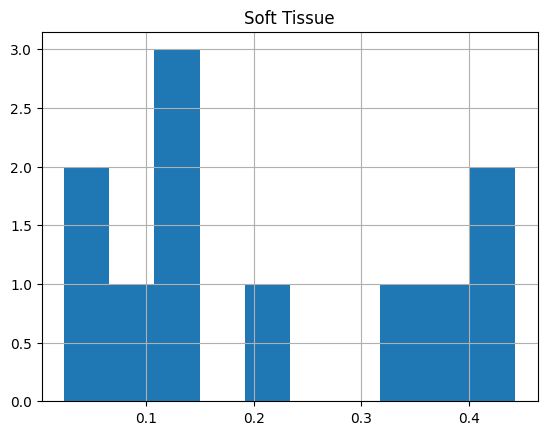

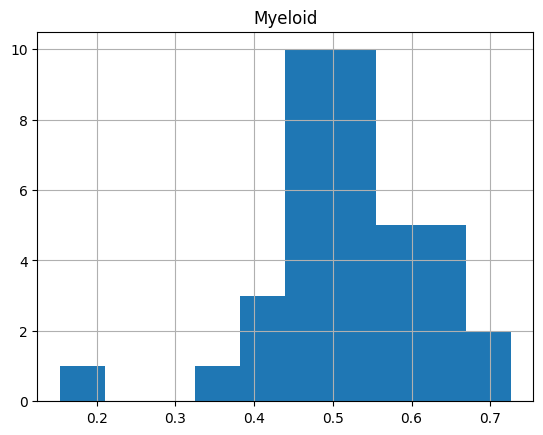

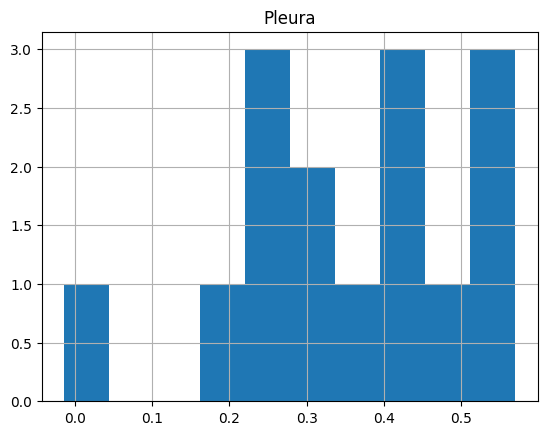

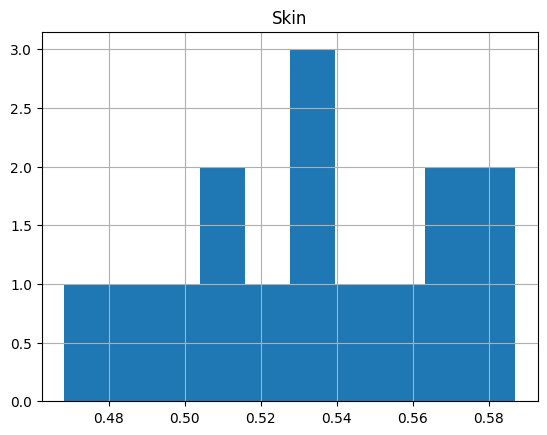

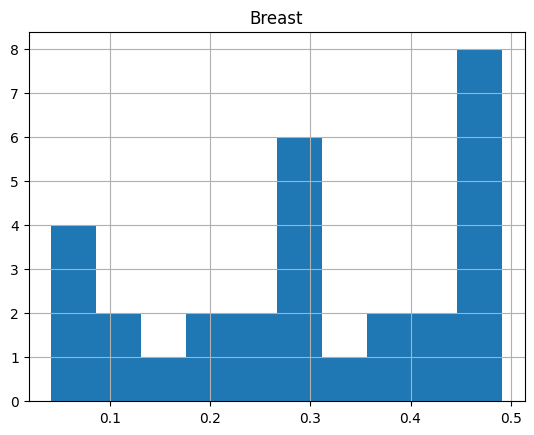

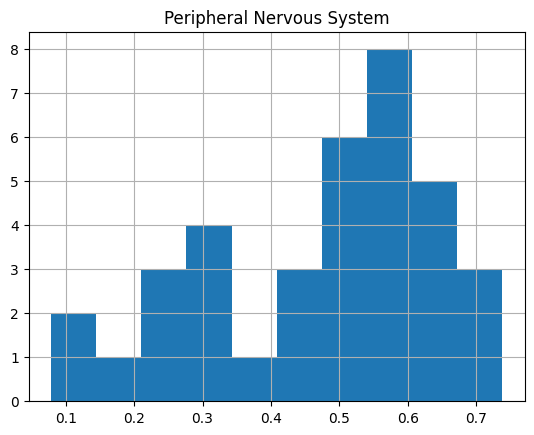

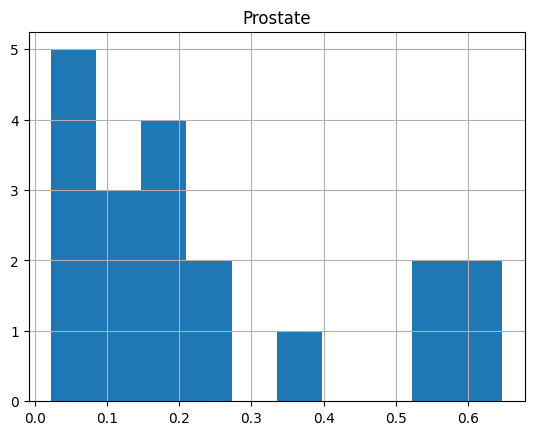

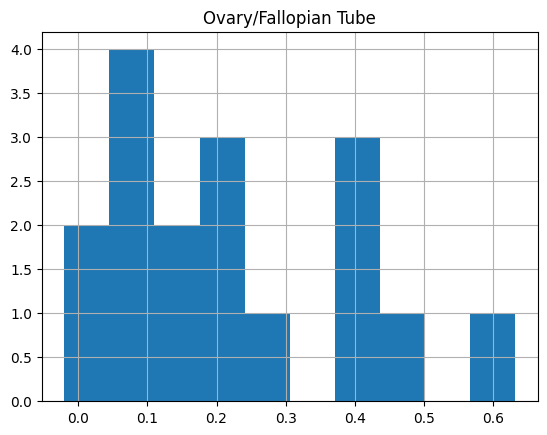

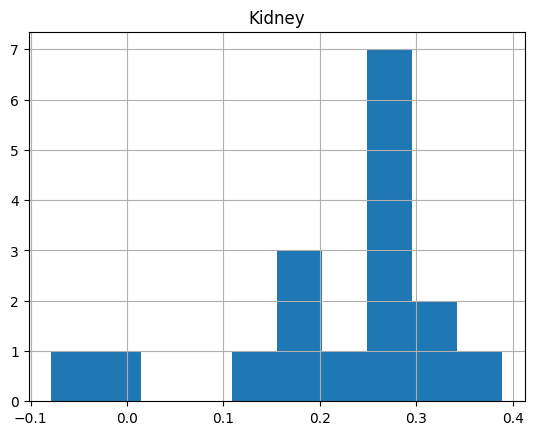

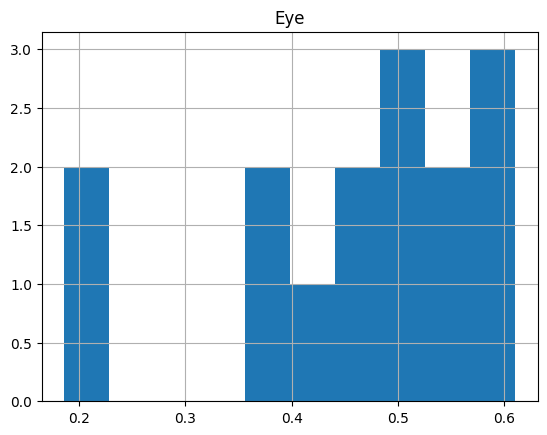

In [293]:
import matplotlib.pyplot as plt

def plot_histograms(projections, updated):
    """
    Filters the projections DataFrame based on subtypes in unique_df and plots histograms for each subtype.

    Parameters:
    - projections (DataFrame): The DataFrame containing the projection data with sample IDs as index.
    - unique_df (DataFrame): The DataFrame containing the subtype and sample information.
    """
    # Get unique subtypes from unique_df
    lineages = updated['Lineage'].unique()

    for lineage in lineages:
        # Filter unique_df for the current subtype
        sample_ids = updated[updated['Lineage'] == lineage]['sample']
        
        # Filter projections DataFrame based on these sample IDs
       
        filtered_projections = projections.loc[sample_ids, lineage]
            
            # Create a new figure
        plt.figure()
            
            # Plot the histogram
        filtered_projections.hist()
        plt.title(lineage)
            
            # Show the figure
        plt.show()
       

plot_histograms(projections, updated)


In [72]:
projections.loc[unique_df[unique_df.Lineage=='adeno'].sampleID, 'adeno']

ACH-000507    0.230119
ACH-000108    0.042923
ACH-000243    0.038287
ACH-000678   -0.018828
ACH-000911    0.015382
                ...   
ACH-003631    0.088317
ACH-003318   -0.207560
ACH-002743    0.090575
ACH-002025    0.095568
ACH-002664   -0.063731
Name: adeno, Length: 257, dtype: float64

In [ ]:
#get the sampleIDS for a given lineage 
print((', ').join(unique_df[unique_df.new_subtype=='adeno']['sample'].tolist()))

In [271]:
subtype_projections=pd.read_csv('/Users/nabdirah/Project1/subtype_projections.csv')
subtype_projections.rename(columns={'Unnamed: 0':'sampleID'}, inplace=True)
subtype_projections=subtype_projections.set_index('sampleID')

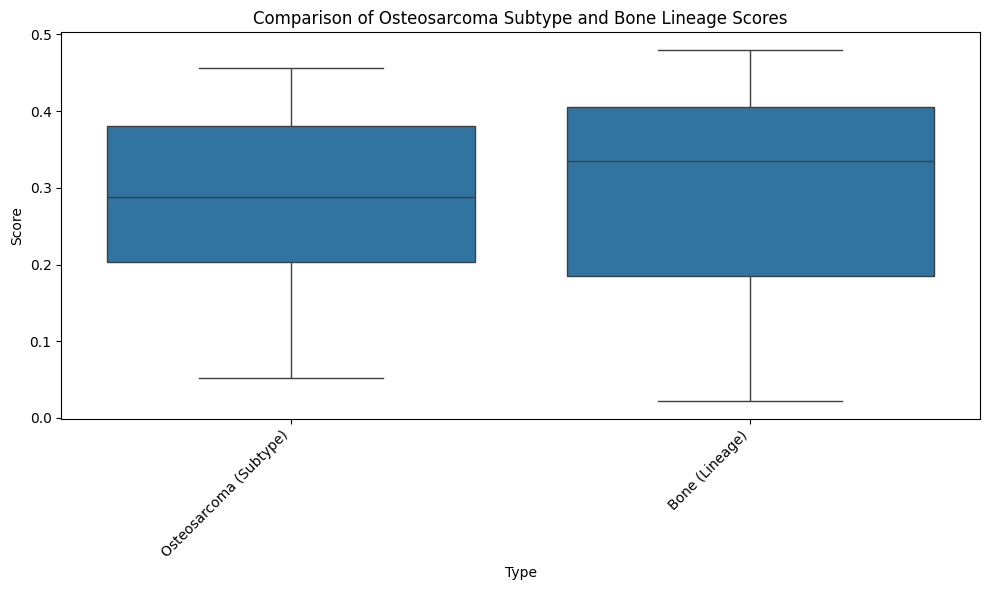

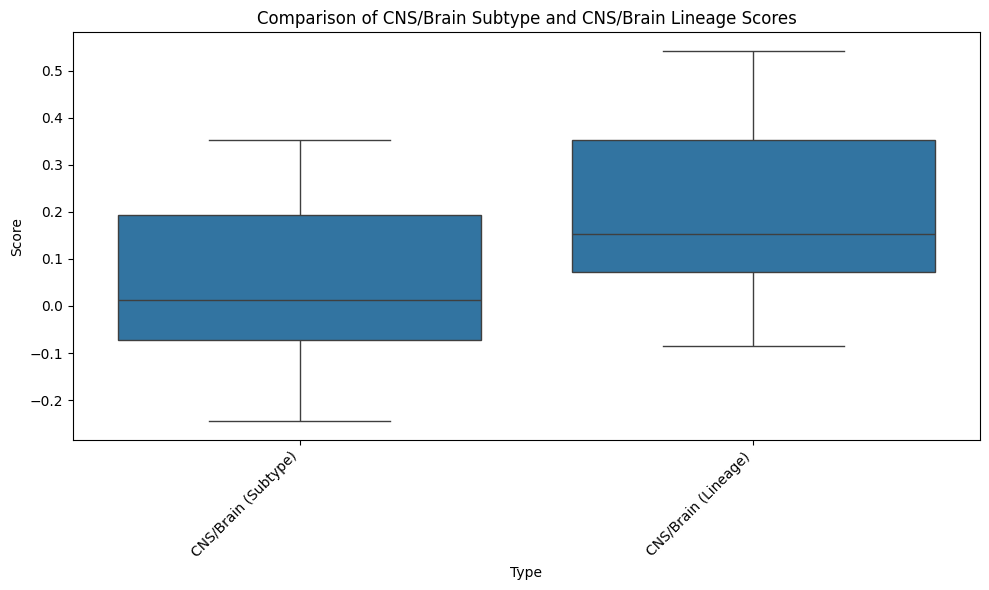

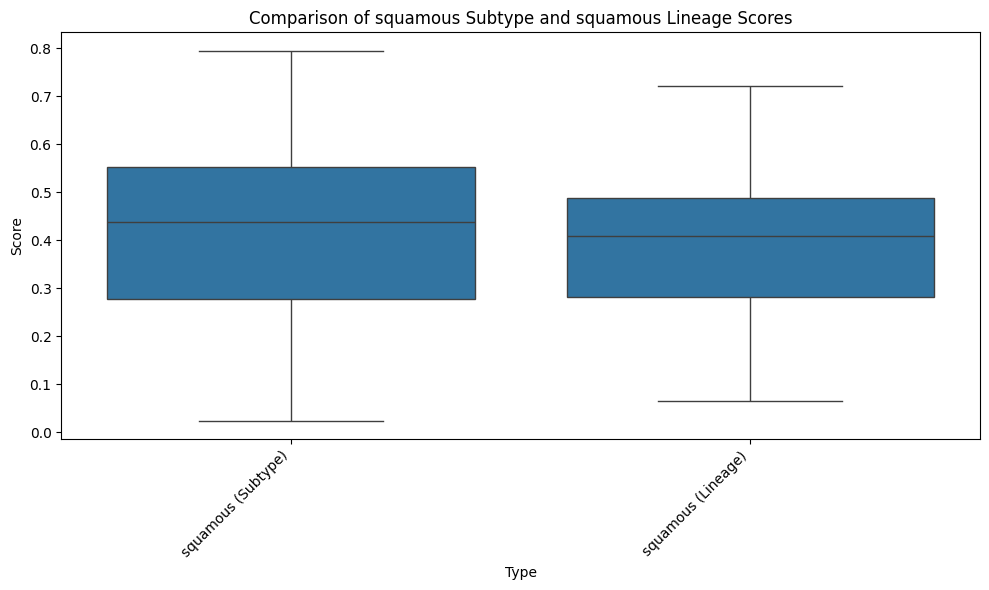

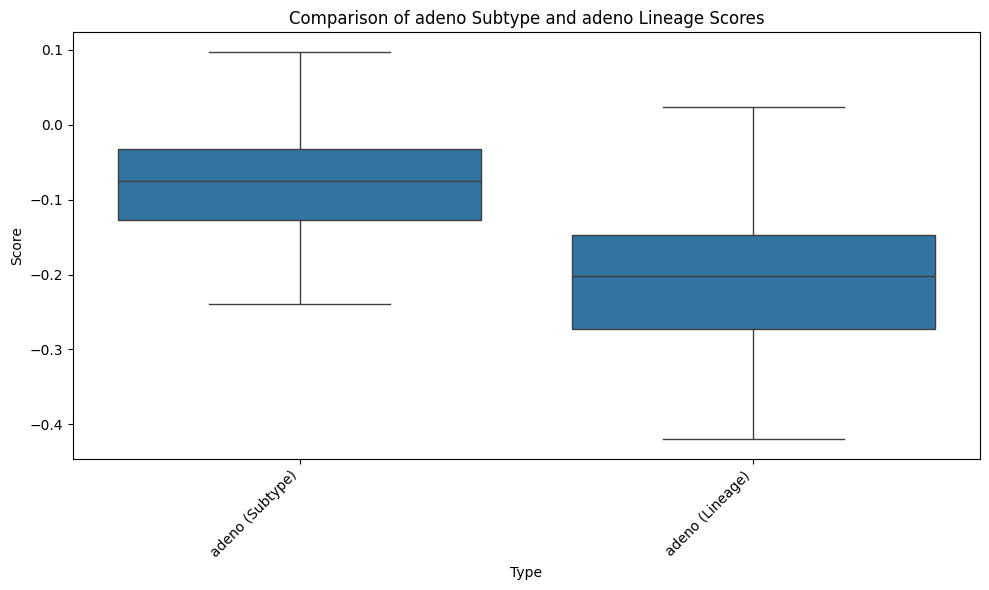

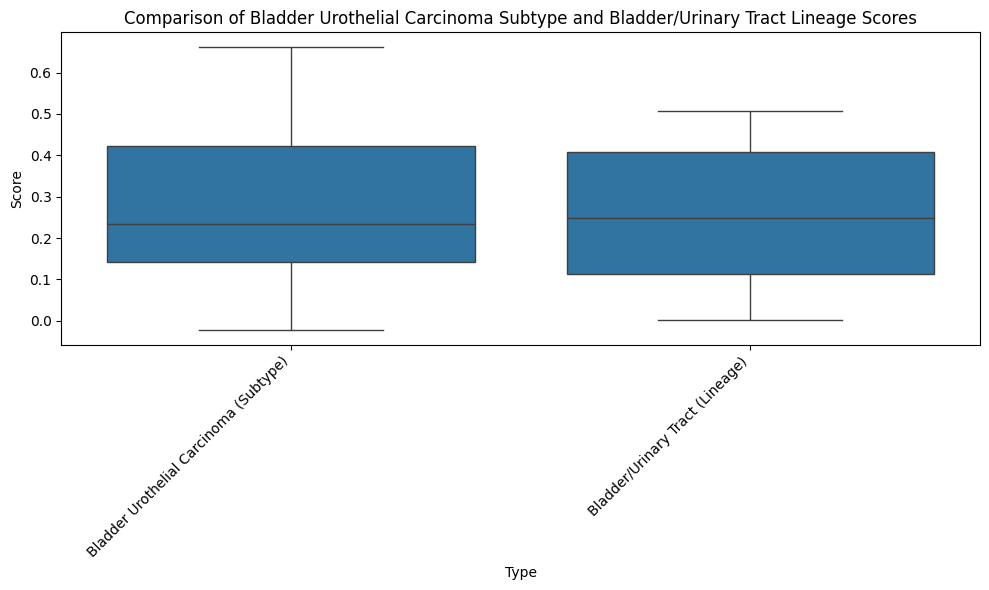

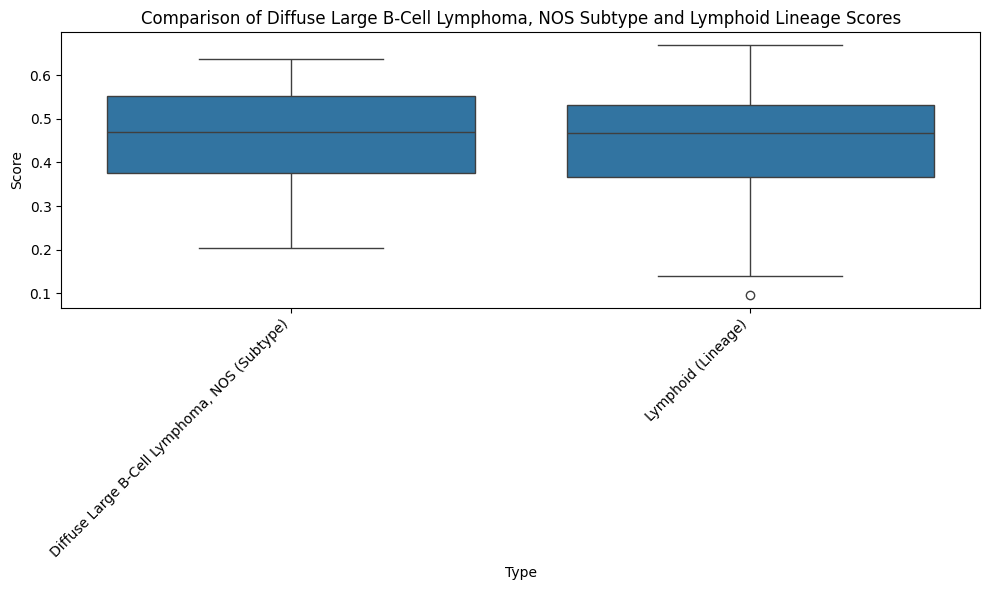

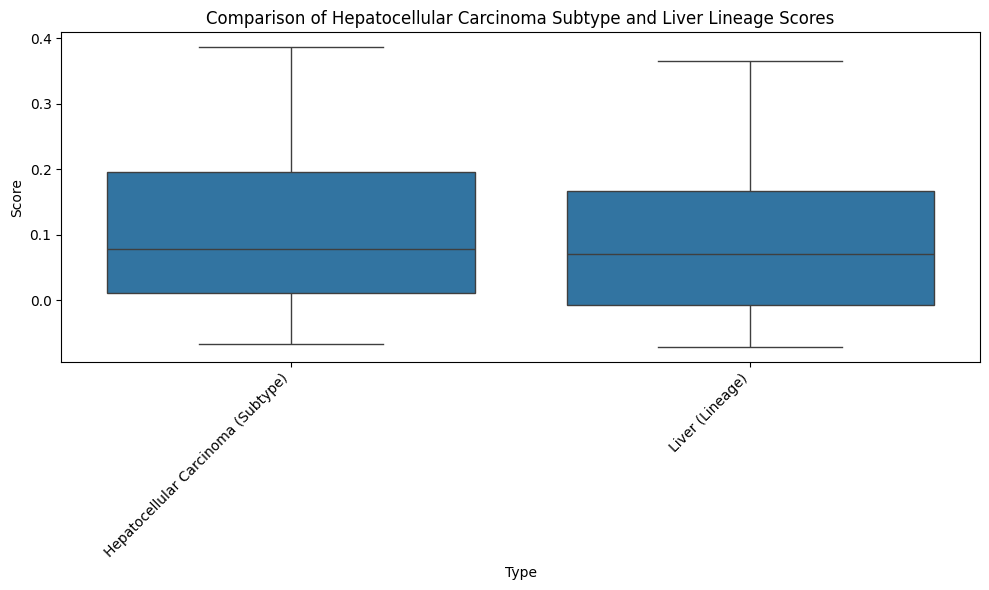

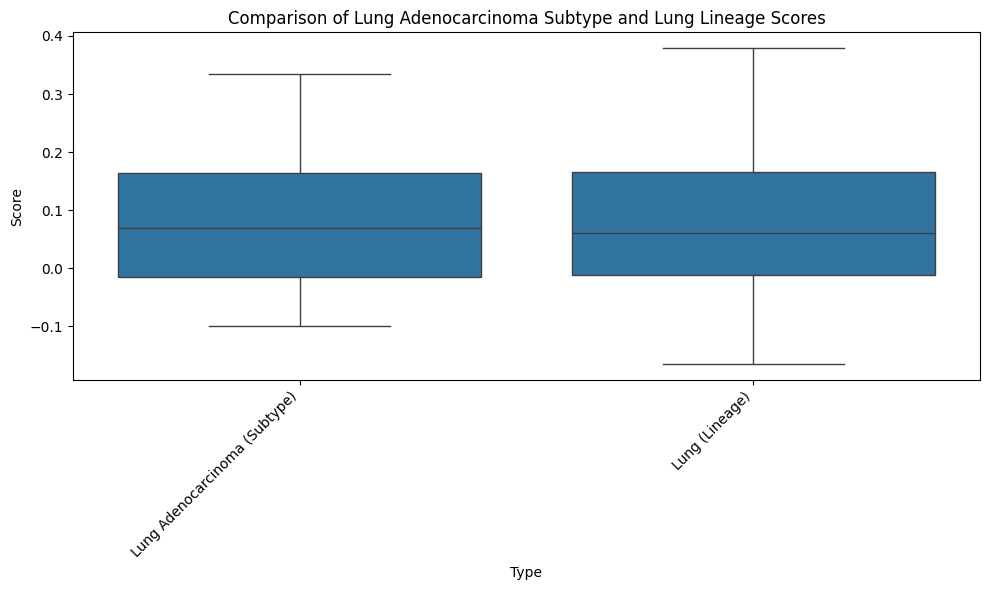

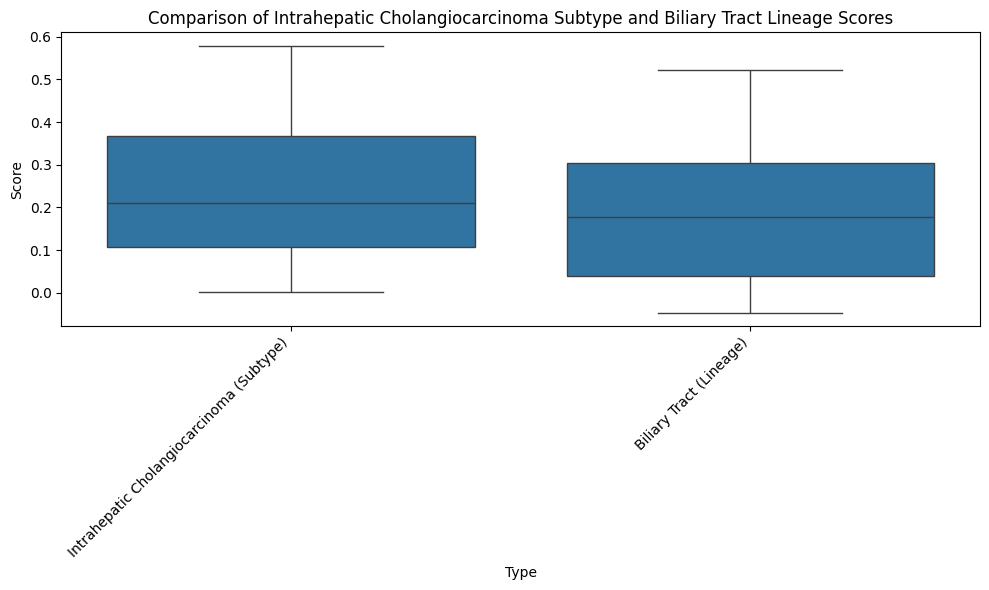

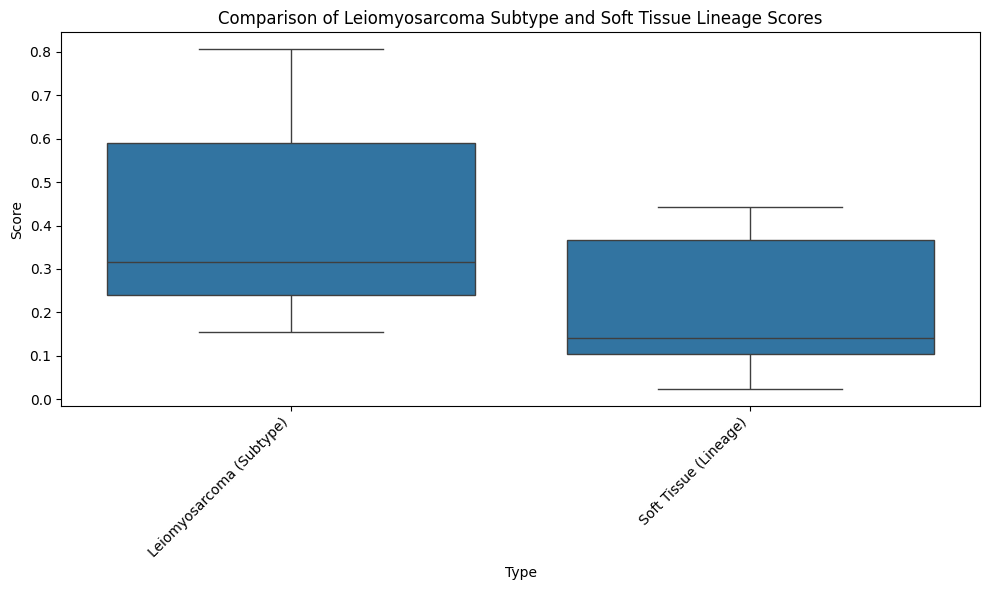

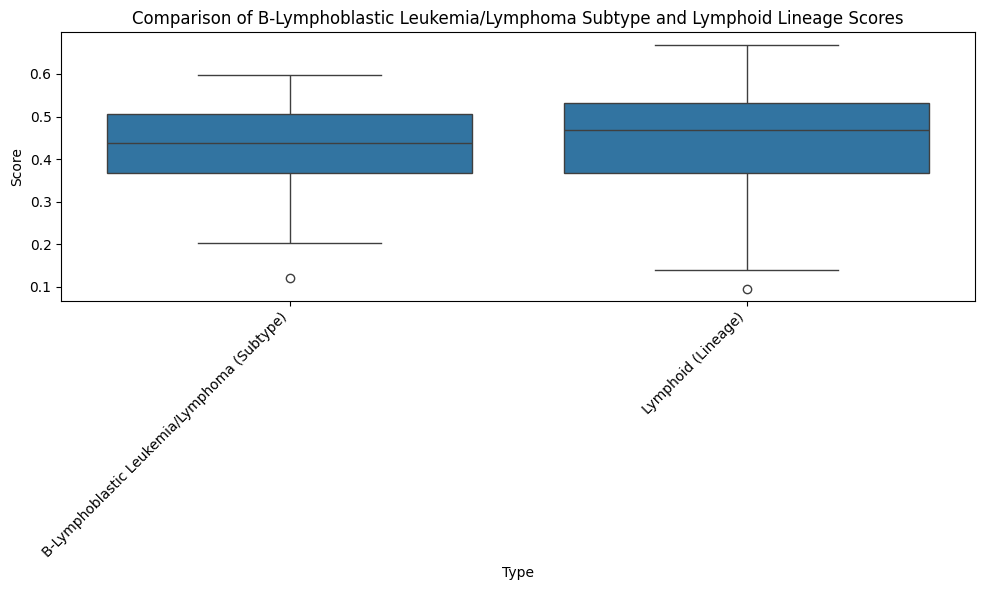

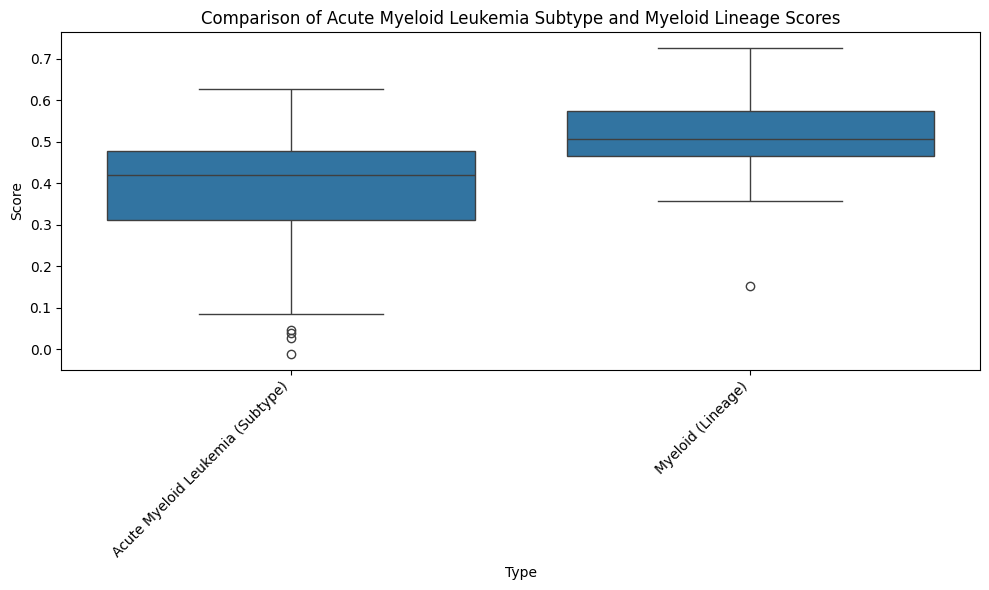

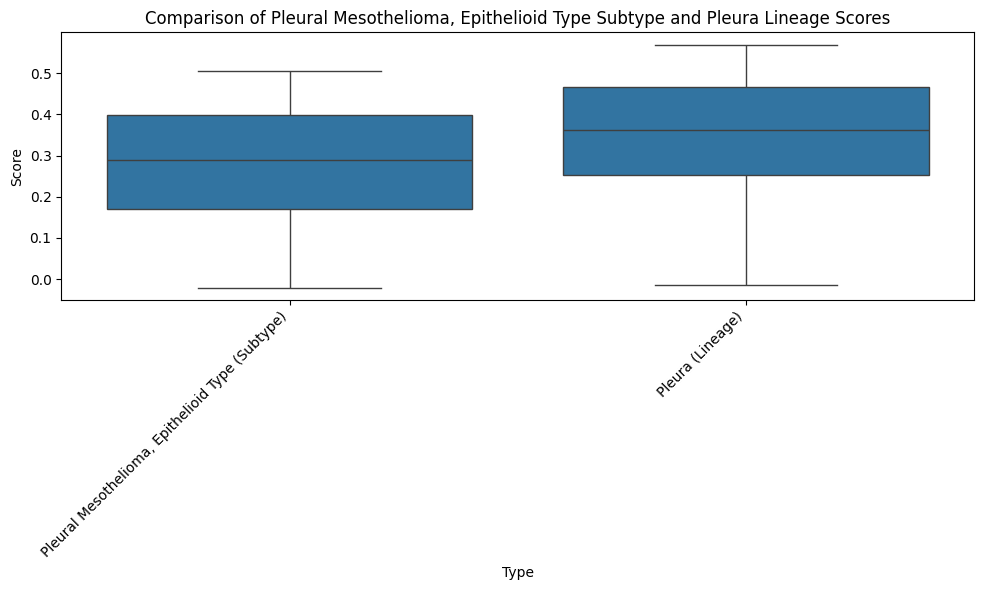

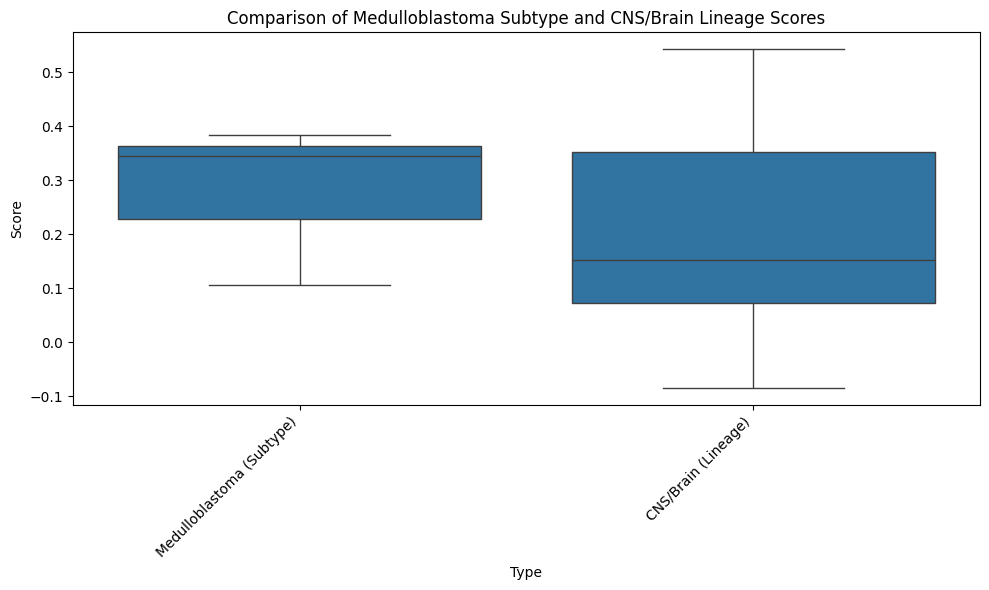

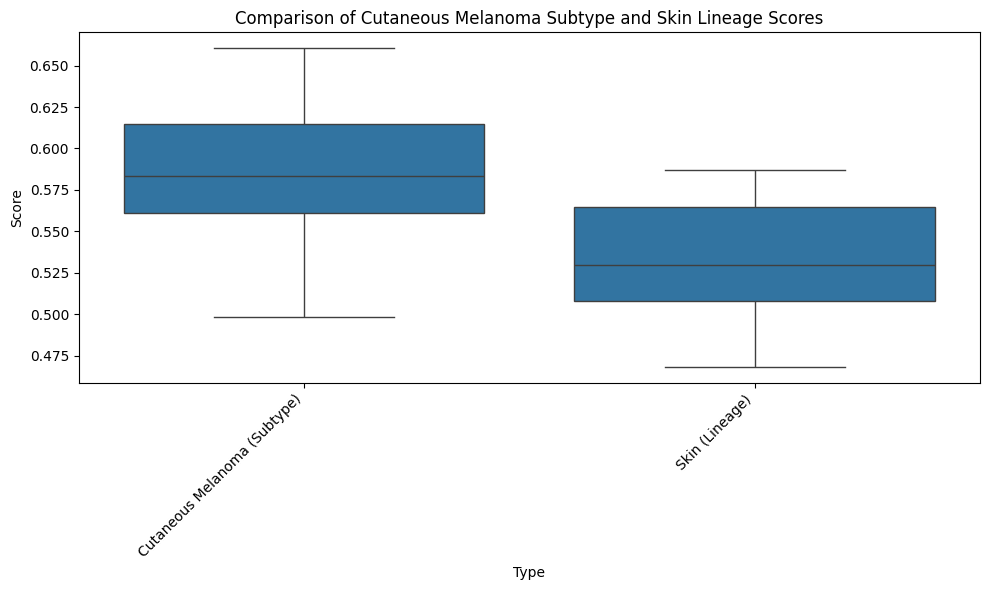

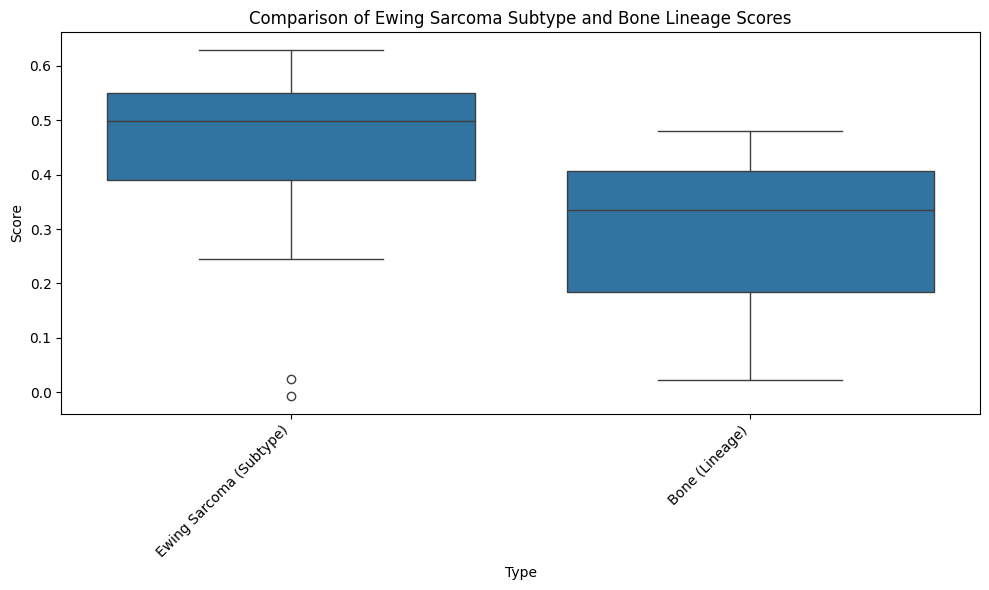

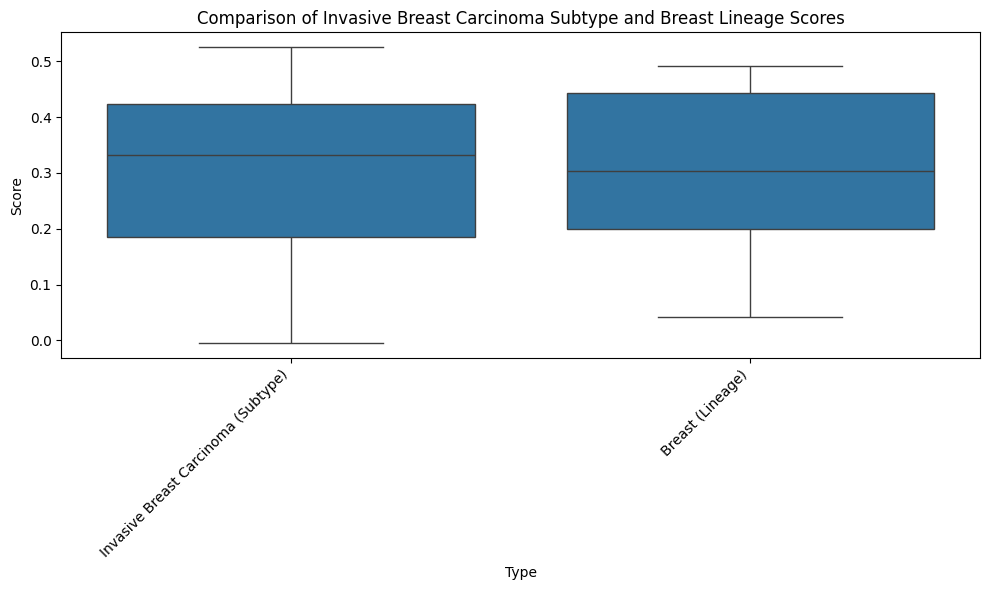

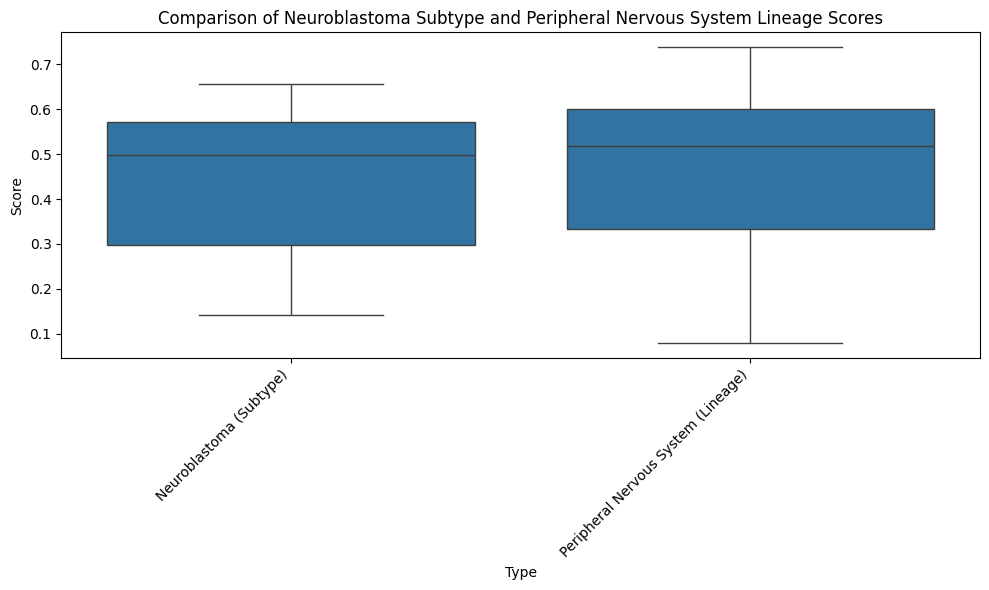

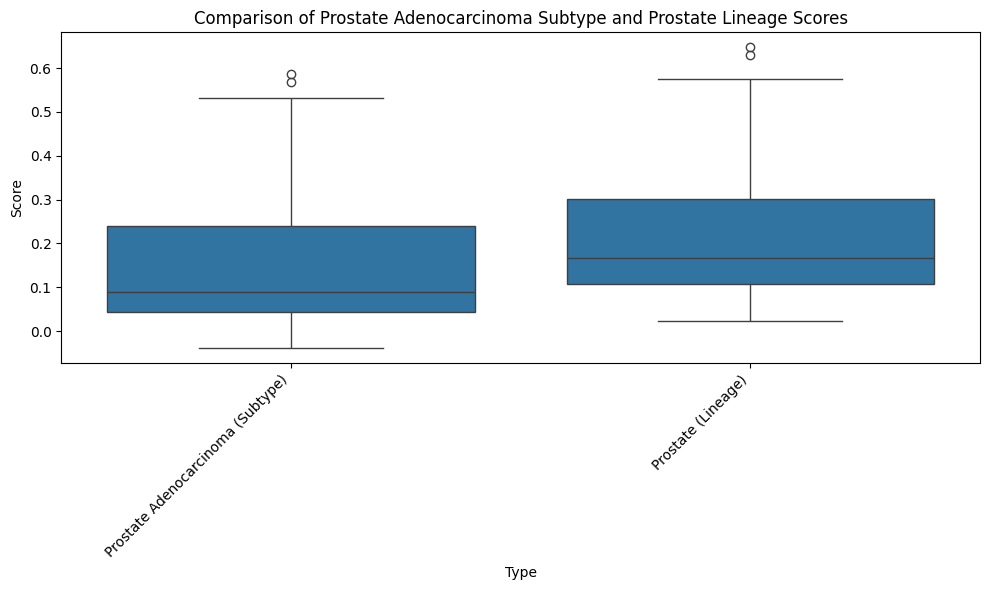

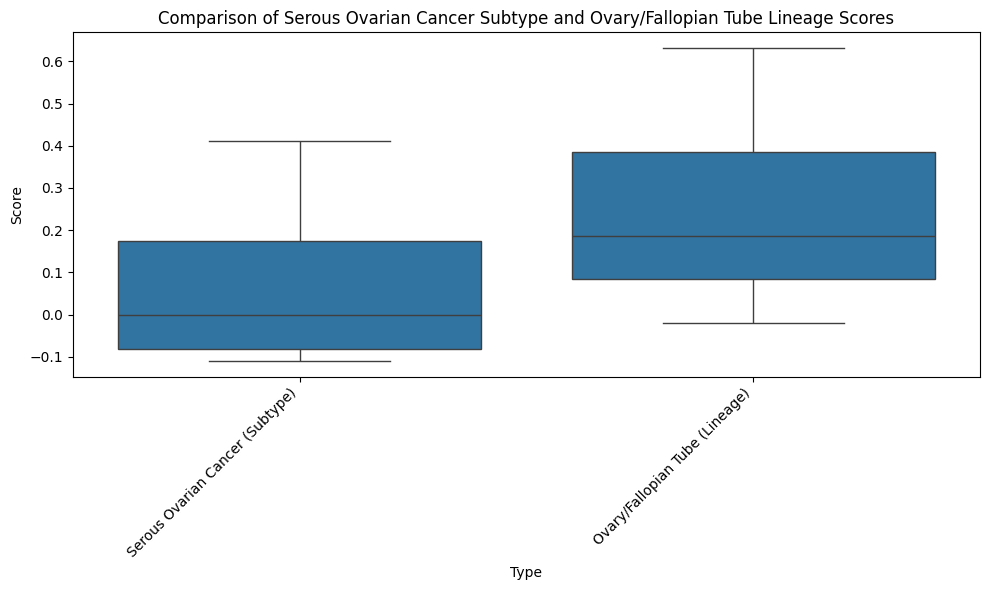

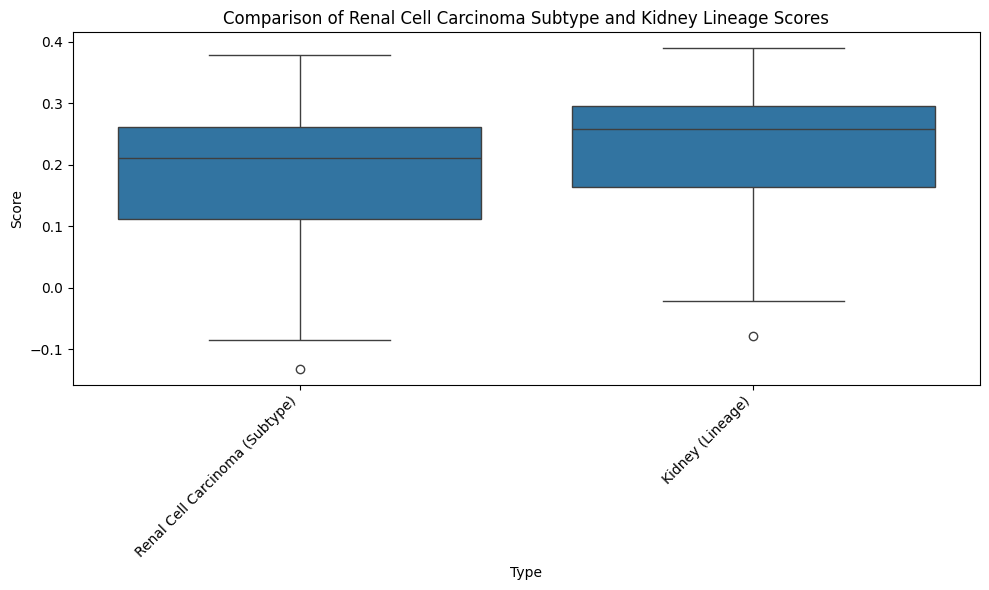

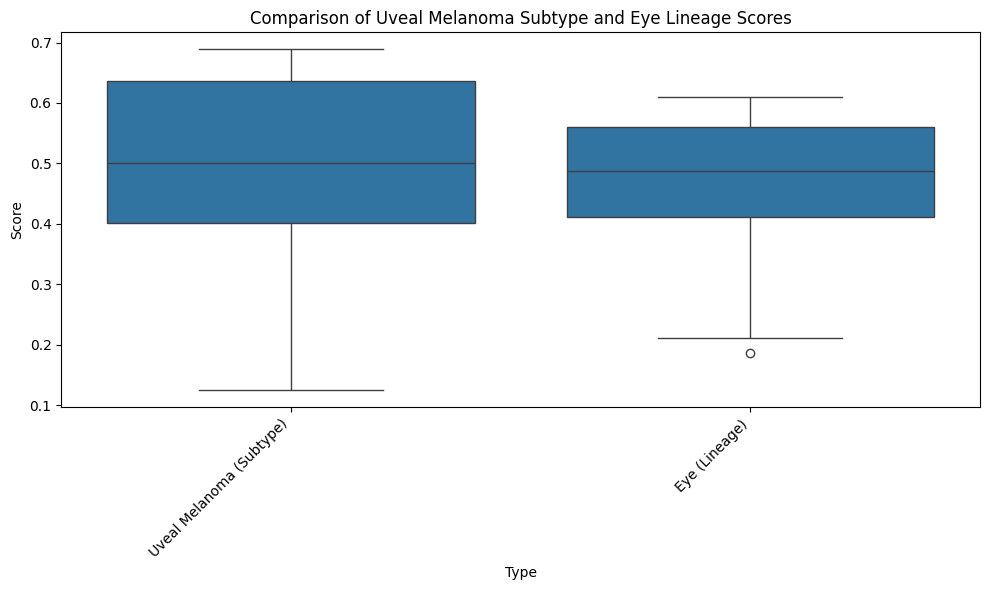

In [294]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# a boxplot where one of the boxes is the subtype scores and one is the lineage ones
for new_subtype in updated['new_subtype'].unique():
    lineage = updated[updated['new_subtype'] == new_subtype]['Lineage'].iloc[0]
    subtype_samples = updated[updated['new_subtype'] == new_subtype]['sample']
    lineage_samples =updated[updated['Lineage'] == lineage]['sample']
    
    # Collect subtype scores
    subtype_scores = subtype_projections.loc[subtype_samples, new_subtype].values
    # Collect lineage scores
    lineage_scores = projections.loc[lineage_samples, lineage].values
    combined_df = pd.DataFrame({
        'Score': list(subtype_scores) + list(lineage_scores),
        'Type': [f'{new_subtype} (Subtype)'] * len(subtype_scores) + [f'{lineage} (Lineage)'] * len(lineage_scores)
    })

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Type', y='Score', data=combined_df, order=combined_df['Type'].unique())
    plt.title(f'Comparison of {new_subtype} Subtype and {lineage} Lineage Scores')
    plt.xticks(rotation=45, ha='right') 
    plt.xlabel('Type')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()


In [295]:
projections.loc['ACH-001456']

Bone                        -0.127123
CNS/Brain                   -0.113486
Myeloid                      0.161412
Soft Tissue                 -0.163486
Lymphoid                     0.035560
Peripheral Nervous System   -0.000853
adeno                       -0.246267
Liver                        0.072169
Adrenal Gland                0.059293
Eye                          0.109727
Lung                        -0.086259
Testis                       0.098127
Bowel                        0.848870
Biliary Tract               -0.002666
Thymus                      -0.014486
Pleura                      -0.136556
Skin                        -0.012588
Kidney                      -0.020807
Prostate                     0.067626
Uterus                       0.111018
Breast                      -0.042015
squamous                     0.070854
Ovary/Fallopian Tube         0.124984
Thyroid                     -0.006067
Bladder/Urinary Tract        0.113795
Name: ACH-001456, dtype: float64